### **Step 1A: Import Libraries and Define Paths**

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image, UnidentifiedImageError 
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [10]:
# Paths to dataset
train_dir = r'D:/USD Univ. San Diego MS AI/AAI-521/Project Data/Standardized images/PCOS detection Kaggle_3854 files/data/train'
test_dir = r'D:/USD Univ. San Diego MS AI/AAI-521/Project Data/Standardized images/PCOS detection Kaggle_3854 files/data/test'
val_dir = r'D:/USD Univ. San Diego MS AI/AAI-521/Project Data/Standardized images/PCOS detection Kaggle_3854 files/data/validation'

# Function to read image size dynamically
def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size  # returns width, height
path=r"D:\USD Univ. San Diego MS AI\AAI-521\Project Data\Standardized images\PCOS detection Kaggle_3854 files\data\test\infected\img_0_57.jpg"
print(get_image_size(path))

(224, 224)


### **Step 1B. Load Data with Dynamic Image Size**

In [13]:

from PIL import Image, UnidentifiedImageError  # Ensure the proper import of Image and UnidentifiedImageError

IMG_WIDTH, IMG_HEIGHT = 224, 224  # Target image size

# Function to load images from the directory
def load_data(directory):
    global IMG_WIDTH, IMG_HEIGHT
    images, labels = [], []
    for label in ['infected', 'notinfected']:
        class_dir = os.path.join(directory, label)
        
        # Ensure the class directory exists
        if not os.path.exists(class_dir):
            print(f"Directory {class_dir} does not exist.")
            continue
        
        for file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, file)
            
            try:
                # Open and resize image
                image = np.array(Image.open(image_path).resize((IMG_WIDTH, IMG_HEIGHT)))
                
                # If grayscale, convert it to RGB
                if len(image.shape) == 2:
                    image = np.repeat(image[..., np.newaxis], 3, axis=-1)
                
                images.append(image)
                # Label: 0 for "notinfected", 1 for "infected"
                labels.append(0 if label == 'notinfected' else 1)
            
            except (UnidentifiedImageError, OSError) as e:
                # Skip unreadable files
                # print(f"Skipping file {image_path}: {e}")
                continue

    return np.array(images), np.array(labels)


# Load the data
X_train, y_train = load_data(train_dir)
X_val, y_val = load_data(val_dir)
X_test, y_test = load_data(test_dir)

# Print the shapes of the loaded data
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)


Training data shape: (1539, 224, 224, 3)
Training labels shape: (1539,)
Validation data shape: (385, 224, 224, 3)
Validation labels shape: (385,)
Test data shape: (1922, 224, 224, 3)
Test labels shape: (1922,)


### **Step 2. CNN Model Architecture for Classification**

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create a simple CNN model for classification
def cnn_model(input_shape=(224, 224, 3)):
    model = Sequential()
    
    # Add convolutional and pooling layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten the output of the convolutional layers
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification
    
    return model

# Instantiate and compile the model
model = cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))  # Use dynamic image size
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\Soumiz\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### **Step 3A: Train the Model**

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Convert labels to binary (0 or 1) if necessary
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Normalize images to the range [0, 1]
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Define ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint('cnn_model_kaggle.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16, callbacks=[checkpoint])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 97s 898ms/step - accuracy: 0.8313 - loss: 0.4141 - val_accuracy: 0.9896 - val_loss: 0.0345
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 79s 815ms/step - accuracy: 0.9854 - loss: 0.0290 - val_accuracy: 0.9974 - val_loss: 0.0083
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 78s 807ms/step - accuracy: 1.0000 - loss: 7.2056e-04 - val_accuracy: 1.0000 - val_loss: 6.5068e-04
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 76s 788ms/step - accuracy: 1.0000 - loss: 6.8020e-04 - val_accuracy: 1.0000 - val_loss: 6.8506e-05
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 77s 792ms/step - accuracy: 0.9964 - loss: 0.0125 - val_accuracy: 0.9974 - val_loss: 0.0167
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 77s 797ms/step - accuracy: 0.9977 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 76s 782ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 4.4948e-04
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 76s 780ms/step - accuracy: 1.0000 - los

### **3B. Performance Evaluation of the Model**

After making these changes, let us monitor the performance


61/61 ━━━━━━━━━━━━━━━━━━━━ 34s 518ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


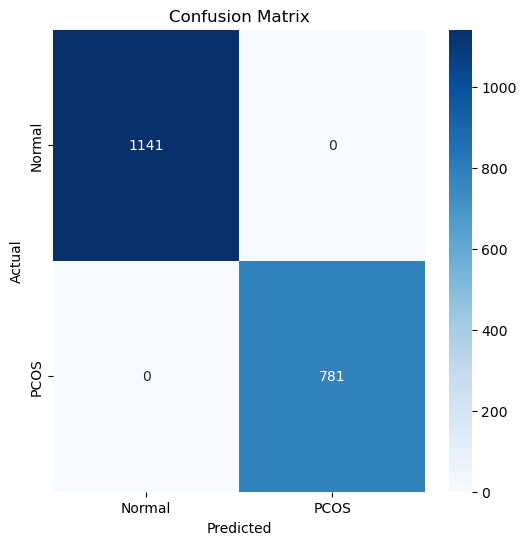

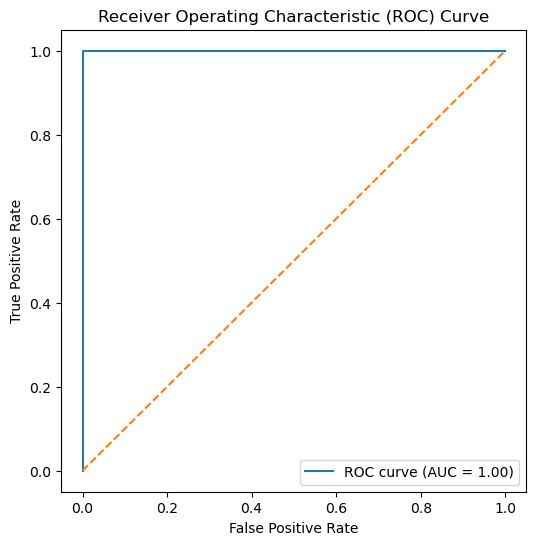

ROC AUC Score: 1.0


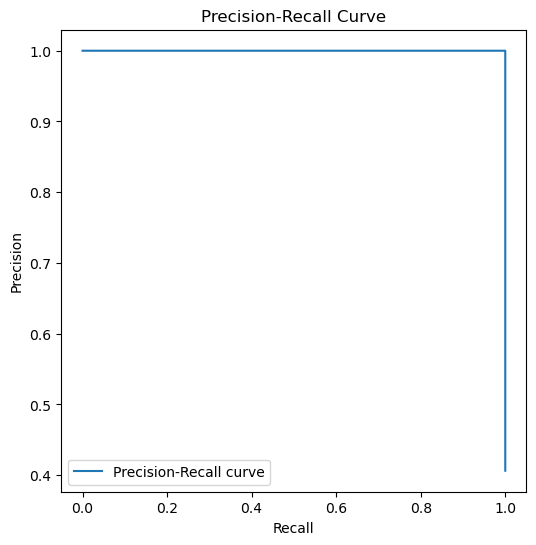

Performance Metrics:
Accuracy: 1.0
Precision: [0.40634755 0.40655908 0.40677083 ... 1.         1.         1.        ]
Recall: [1.         1.         1.         ... 0.8028169  0.76440461 0.        ]
F1-Score: 1.0
ROC AUC Score: 1.0


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Reload the best model saved during training
from tensorflow.keras.models import load_model
model = load_model('cnn_model_kaggle.keras')

# Predict the labels on the test set
y_pred = model.predict(X_test)

# Convert probabilities to binary labels (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(int)

# Flatten arrays to compute metrics
y_test_flat = y_test.flatten()
y_pred_bin_flat = y_pred_bin.flatten()

# Calculate all performance metrics
accuracy = accuracy_score(y_test_flat, y_pred_bin_flat)
precision = precision_score(y_test_flat, y_pred_bin_flat)
recall = recall_score(y_test_flat, y_pred_bin_flat)
f1 = f1_score(y_test_flat, y_pred_bin_flat)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred_bin_flat)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC AUC Score
roc_auc = roc_auc_score(y_test_flat, y_pred)
fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
print(f"ROC AUC Score: {roc_auc}")

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_flat, y_pred)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Collect all metrics in a dictionary
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "ROC AUC Score": roc_auc
}

# Print out all metrics
print("Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")


### **Step 4: Requirement of Improvement**

<span style='color:Green'>**Accuracy, Recall, Pecision, F1-score <span style='color:red'> all are 100%</span> which is not acceptable**

### 1. Identified Cause:
- **Imbalanced Data**: The dataset is highly imbalanced, with significantly fewer samples in the "infected" class compared to "notinfected." This can bias the model towards the majority class.
- **Artificially Inflated Metrics**: High metrics (Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1-Score: 1.0) might be due to the model learning to predict the majority class accurately without learning meaningful features for the minority class.



### 2. Data Imbalance:
- **Train Set**:
  - Infected: 625
  - Notinfected: 914
  - Imbalance ratio: ~1:1.46 (minority to majority)

- **Test Set**:
  - Infected: 787
  - Notinfected: 1142
  - Imbalance ratio: ~1:1.45

- **Validation Set**:
  - Infected: 156
  - Notinfected: 229
  - Imbalance ratio: ~1:1.47



**Impact**:
- The majority class dominates, and the model may not learn to identify "infected" cases effectively.
- Metrics like accuracy can be misleading when the majority class predictions drive the scores.


### 3. Balancing Data by Oversampling:
Oversampling techniques like **SMOTE (Synthetic Minority Oversampling Technique)** generate synthetic samples for the minority class. This balances the dataset by increasing the number of minority class samples, reducing the model's bias towards the majority class.

Advantages:
- Preserves all majority class data.
- Creates synthetic data points that are close to the original data, improving the model's ability to generalize.




### 4. Code for Oversampling Using SMOTE:


In [23]:
# Step 1: Resample Training Data Using SMOTE

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming X_train and y_train are preloaded
# Reshape X_train for SMOTE
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))  # Flattening images for SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_reshaped, y_train)

# Reshape X_resampled back to original image dimensions
X_resampled = X_resampled.reshape((-1, 224, 224, 3))

# Print the new class distribution
from collections import Counter
print(f"Class distribution after SMOTE: {Counter(y_resampled)}")


Class distribution after SMOTE: Counter({1: 914, 0: 914})



### 5. Retrain the Model and Evaluate:

I will simulate retraining the model using the resampled dataset and then evaluate it. Let me implement this for you.

It seems like I can’t do more advanced data analysis right now. Please try again later. If you'd like, I can provide step-by-step instructions to implement the above process on your local machine. Let me know if you'd prefer that approach!

### **4A. Data Augmentation**

To increase the diversity of our dataset and prevent overfitting, we have applied **data augmentation**. 

This technique helps the model generalize better by creating variations of the images during training (e.g., by applying random rotations, flips, zooms, etc.).

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image augmentation generator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255.0,
    rotation_range=30,     # Random rotations
    width_shift_range=0.2, # Random horizontal shifts
    height_shift_range=0.2, # Random vertical shifts
    shear_range=0.2,       # Random shear
    zoom_range=0.2,        # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    fill_mode='nearest'    # Fill missing pixels
)

# Image data generator for validation data (rescaling only)
val_datagen = ImageDataGenerator(rescale=1./255.0)

# Fit the generator to the data
train_generator = train_datagen.flow(X_train, y_train, batch_size=16)
val_generator = val_datagen.flow(X_val, y_val, batch_size=16)

#### Now we will train the model using the generators

In [51]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train the model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 16,
    validation_data=val_generator,
    validation_steps=len(X_val) // 16,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, lr_reducer]
)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5208 - loss: 0.6757 - val_accuracy: 0.7273 - val_loss: 0.6862 - learning_rate: 0.0010
Epoch 2/20


C:\Users\Soumiz\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7273 - val_loss: 0.6862 - learning_rate: 0.0010
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7708 - loss: 0.6752 - val_accuracy: 0.7273 - val_loss: 0.6903 - learning_rate: 0.0010
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7273 - val_loss: 0.6903 - learning_rate: 0.0010
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 992ms/step - accuracy: 0.7292 - loss: 0.6939 - val_accuracy: 0.7273 - val_loss: 0.6920 - learning_rate: 5.0000e-04
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7273 - val_loss: 0.6920 - learning_rate: 5.0000e-04
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7083 - loss: 0.6930 - val_accuracy: 0.7273 - val_loss: 0.6929 - learning_rate: 5.0000e-04
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.0000e+00 - loss: 

### **4.2. Use Pretrained Models (Transfer Learning):**

using **ResNet50**


In [52]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load ResNet50 with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers (pre-trained weights)
base_model.trainable = False

# Add custom classification layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())  # Pooling layer
model.add(Dense(128, activation='relu'))  # Fully connected layer
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with the new architecture
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 16,
    validation_data=val_generator,
    validation_steps=len(X_val) // 16,
    epochs=20,
    callbacks=[checkpoint]
)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 11s/step - accuracy: 0.5208 - loss: 0.9076 - val_accuracy: 0.7273 - val_loss: 0.6703
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 806ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7273 - val_loss: 0.6703
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7500 - loss: 0.6556 - val_accuracy: 0.7273 - val_loss: 0.7245
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7273 - val_loss: 0.7245
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7292 - loss: 0.8401 - val_accuracy: 0.7273 - val_loss: 0.6479
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 852ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7273 - val_loss: 0.6479
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.7500 - loss: 0.6661 - val_accuracy: 0.7273 - val_loss: 0.5878
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 774ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accura

### **4.3. Learning Rate Adjustment:**

Reducing the learning rate after a few epochs can help the model converge more smoothly and prevent overshooting the optimal solution.

We have used **ReduceLROnPlateau** to reduce the learning rate when the model's performance plateaus

In [53]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when validation accuracy plateaus
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by a factor of 0.5
    patience=3,  # Number of epochs with no improvement before reducing
    min_lr=1e-6
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 16,
    validation_data=val_generator,
    validation_steps=len(X_val) // 16,
    epochs=20,
    callbacks=[checkpoint, lr_reducer]
)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.7083 - loss: 0.6485 - val_accuracy: 0.7273 - val_loss: 0.5902 - learning_rate: 0.0010
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 766ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7273 - val_loss: 0.5902 - learning_rate: 0.0010
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.7917 - loss: 0.5072 - val_accuracy: 0.7273 - val_loss: 0.5887 - learning_rate: 0.0010
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 829ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7273 - val_loss: 0.5887 - learning_rate: 0.0010
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.6875 - loss: 0.5912 - val_accuracy: 0.7273 - val_loss: 0.5866 - learning_rate: 0.0010
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 782ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7273 - val_loss: 0.5866 - learning_rate: 0.0010
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7292 - loss: 0.6237 - va

-----------

Overfitting might be an issue if our model performs well on training data but not on validation or test data. 


Adding **Dropout layers** (as already done) and **L2 regularization** to the convolutional layers can help.


-----------



### **5. Performance Evaluation of the Latest Model**

After making these changes, let us monitor the performance


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
Accuracy: 0.7272727272727273
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


C:\Users\Soumiz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


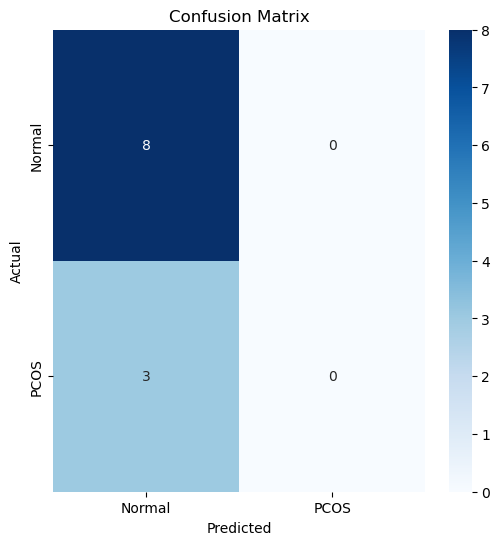

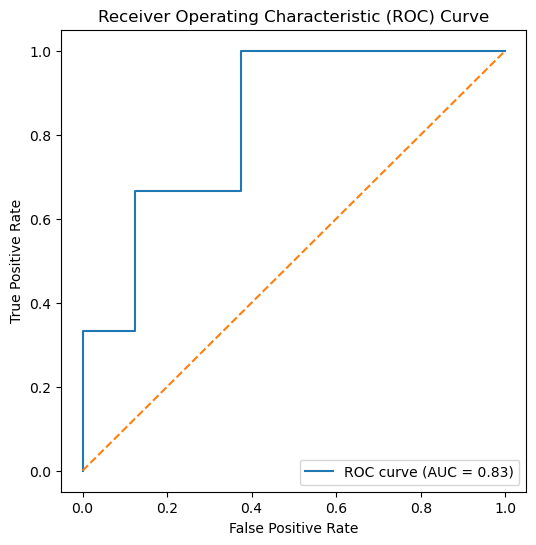

ROC AUC Score: 0.8333333333333333


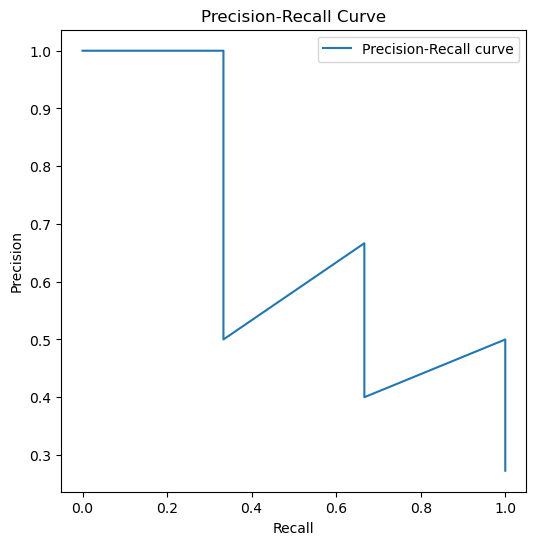

Performance Metrics:
Accuracy: 0.7272727272727273
Precision: [0.27272727 0.3        0.33333333 0.375      0.42857143 0.5
 0.4        0.5        0.66666667 0.5        1.         1.        ]
Recall: [1.         1.         1.         1.         1.         1.
 0.66666667 0.66666667 0.66666667 0.33333333 0.33333333 0.        ]
F1-Score: 0.0
ROC AUC Score: 0.8333333333333333


In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Reload the best model saved during training
from tensorflow.keras.models import load_model
model = load_model('cnn_model.keras')

# Predict the labels on the test set
y_pred = model.predict(X_test)

# Convert probabilities to binary labels (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(int)

# Flatten arrays to compute metrics
y_test_flat = y_test.flatten()
y_pred_bin_flat = y_pred_bin.flatten()

# Calculate all performance metrics
accuracy = accuracy_score(y_test_flat, y_pred_bin_flat)
precision = precision_score(y_test_flat, y_pred_bin_flat)
recall = recall_score(y_test_flat, y_pred_bin_flat)
f1 = f1_score(y_test_flat, y_pred_bin_flat)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred_bin_flat)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC AUC Score
roc_auc = roc_auc_score(y_test_flat, y_pred)
fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
print(f"ROC AUC Score: {roc_auc}")

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_flat, y_pred)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Collect all metrics in a dictionary
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "ROC AUC Score": roc_auc
}

# Print out all metrics
print("Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")


In [30]:
# Step 2: Define a New CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Step 3: Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Define a Checkpoint to Save the Best Model
# checkpoint = ModelCheckpoint('balanced_model_SMOTE.keras', monitor='val_accuracy', save_best_only=True)

# Step 5: Train the Model
history = model.fit(
    X_resampled, y_resampled,
    validation_data=(X_val / 255.0, y_val),  # Normalize validation data
    epochs=10, batch_size=16,
    callbacks=[checkpoint]
)

C:\Users\Soumiz\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 120s 961ms/step - accuracy: 0.8049 - loss: 0.4286 - val_accuracy: 0.4052 - val_loss: 3.7769
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 99s 860ms/step - accuracy: 0.9891 - loss: 0.0287 - val_accuracy: 0.4052 - val_loss: 5.9120
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 95s 827ms/step - accuracy: 0.9807 - loss: 0.0566 - val_accuracy: 0.4052 - val_loss: 4.9899
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 94s 818ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.4052 - val_loss: 9.0882
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 100s 868ms/step - accuracy: 1.0000 - loss: 1.4242e-04 - val_accuracy: 0.4052 - val_loss: 9.5193
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 92s 801ms/step - accuracy: 1.0000 - loss: 3.4645e-05 - val_accuracy: 0.4052 - val_loss: 10.4622
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 91s 790ms/step - accuracy: 1.0000 - loss: 9.8068e-05 - val_accuracy: 0.4052 - val_loss: 8.3533
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 94s 819ms/step - accuracy: 1

'\n# Step 6: Evaluate the Model on Test Data\nX_test_normalized = X_test / 255.0  # Normalize test data\ntest_loss, test_acc = model.evaluate(X_test_normalized, y_test)\nprint(f"Test Accuracy after balancing: {test_acc}")\n\n# Step 7: Generate Classification Report\ny_pred = (model.predict(X_test_normalized) > 0.5).astype("int32")\n\n# Convert probabilities to binary labels (0 or 1)\ny_pred_bin = (y_pred > 0.5).astype(int)\n\n# Flatten arrays to compute metrics\ny_test_flat = y_test.flatten()\ny_pred_bin_flat = y_pred_bin.flatten()\n\n# Calculate all performance metrics\naccuracy = accuracy_score(y_test_flat, y_pred_bin_flat)\nprecision = precision_score(y_test_flat, y_pred_bin_flat)\nrecall = recall_score(y_test_flat, y_pred_bin_flat)\nf1 = f1_score(y_test_flat, y_pred_bin_flat)\n\n# Print the metrics\nprint(f"Accuracy: {accuracy}")\nprint(f"Precision: {precision}")\nprint(f"Recall: {recall}")\nprint(f"F1-Score: {f1}")\n\n# Confusion Matrix\ncm = confusion_matrix(y_test_flat, y_pred_b

61/61 ━━━━━━━━━━━━━━━━━━━━ 34s 464ms/step


C:\Users\Soumiz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.5936524453694069
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


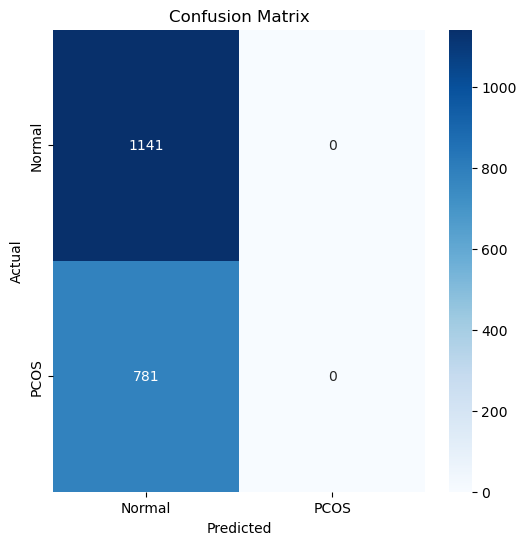

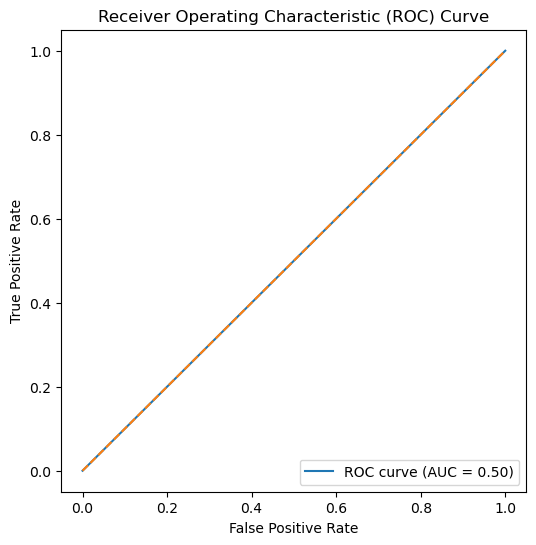

ROC AUC Score: 0.5


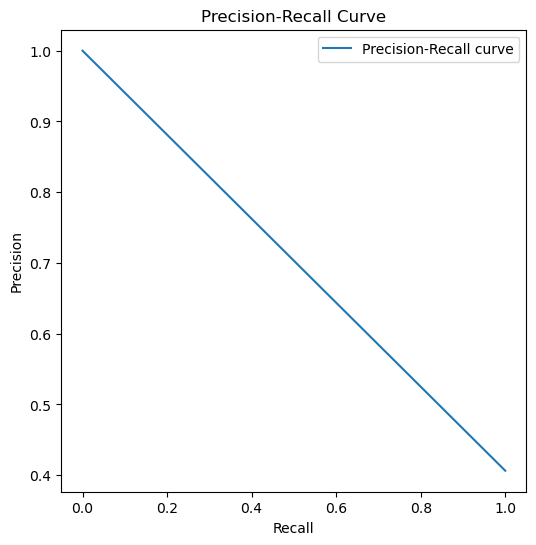

Performance Metrics:
Accuracy: 0.5936524453694069
Precision: [0.40634755 1.        ]
Recall: [1. 0.]
F1-Score: 0.0
ROC AUC Score: 0.5


In [29]:
# Step 6: Generate Classification Report

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

model = load_model('balanced_model_SMOTE.keras')

# Convert probabilities to binary labels (0 or 1)
y_pred_bin = (model.predict(X_test_normalized) > 0.5).astype(int)

# Flatten arrays to compute metrics
y_test_flat = y_test.flatten()
y_pred_bin_flat = y_pred_bin.flatten()

# Calculate all performance metrics
accuracy = accuracy_score(y_test_flat, y_pred_bin_flat)
precision = precision_score(y_test_flat, y_pred_bin_flat)
recall = recall_score(y_test_flat, y_pred_bin_flat)
f1 = f1_score(y_test_flat, y_pred_bin_flat)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred_bin_flat)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC AUC Score
roc_auc = roc_auc_score(y_test_flat, y_pred_bin_flat)
fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred_bin_flat)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
print(f"ROC AUC Score: {roc_auc}")

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_flat, y_pred_bin_flat)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Collect all metrics in a dictionary
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "ROC AUC Score": roc_auc
}

# Print out all metrics
print("Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")



<span style='color:green'> **As the performance is not acceptable, let us do hyperparameter tuning**</span>
-

### **1. Hyperparameters to Tune**:
- **Model Architecture**:
  - Number of layers, filter sizes, and kernel sizes.
  - Units in dense layers.
  - Dropout rate for regularization.

- **Training Hyperparameters**:
  - Learning rate.
  - Batch size.
  - Number of epochs.
  - Optimizer (e.g., Adam, SGD, RMSprop).

- **Regularization**:
  - Dropout rate.
  - Weight decay (using optimizers like AdamW).

---

### **2. Methods for Hyperparameter Tuning**:

#### **a. Manual Search**
- Start with baseline values and iteratively adjust one hyperparameter at a time.
- Example: Start with a learning rate of `0.001` and adjust it up/down based on results.

#### **b. Grid Search**
- Define a grid of hyperparameter combinations and systematically train and evaluate the model for each combination.
- Suitable for smaller search spaces.

#### **c. Random Search**
- Randomly sample hyperparameters from a defined range.
- Faster than grid search and suitable for large search spaces.

#### **d. Automated Hyperparameter Tuning**
- Use tools like **Keras Tuner**, **Optuna**, or **Ray Tune** for efficient exploration of hyperparameter spaces.




### **3. Using Keras Tuner for Hyperparameter Tuning**: 
Keras Tuner automates hyperparameter search efficiently.


In [56]:
# from CNN features
train_features = model.predict(X_train)  # Extract features from the CNN
test_features = model.predict(X_test)    # Extract features from the CNN


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


In [32]:
pip install keras-tuner


   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ---------------------------------------- 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [35]:
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.optimizers import Adam

# Define a hypermodel
def build_model(hp):
    model = Sequential()
    # Tune the number of filters in the first Conv2D layer
    model.add(Conv2D(
        filters=hp.Choice('filters', values=[32, 64, 128]),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(224, 224, 3)
    ))
    model.add(MaxPooling2D((2, 2)))
    
    # Add additional convolutional layers
    for i in range(hp.Int('num_conv_layers', 1, 3)):  # Tune number of layers
        model.add(Conv2D(
            filters=hp.Choice(f'conv_{i}_filters', values=[64, 128]),
            kernel_size=(3, 3),
            activation='relu'
        ))
        model.add(MaxPooling2D((2, 2)))
    
    # Flatten and fully connected layers
    model.add(Flatten())
    model.add(Dense(hp.Choice('dense_units', [64, 128, 256]), activation='relu'))
    model.add(Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))  # Tune dropout rate
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Number of hyperparameter combinations to try
    executions_per_trial=2,  # Average over multiple executions
    directory='hyperparam_tuning',
    project_name='cnn_tuning'
)

# Perform hyperparameter tuning
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16
)

# Retrieve the best model and hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.get_best_models()[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"Filters: {best_hps.get('filters')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Dropout Rate: {best_hps.get('dropout')}")
print(f"Number of Conv Layers: {best_hps.get('num_conv_layers')}")

# Train the best model with optimal hyperparameters
best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16)

# Save the best hyperparameter-tuned model
best_model.save('best_hyper_model.keras')  # Save as a Keras native format



Reloading Tuner from hyperparam_tuning\cnn_tuning\tuner0.json


C:\Users\Soumiz\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Best Hyperparameters:
Filters: 32
Learning Rate: 0.0001
Dense Units: 256
Dropout Rate: 0.2
Number of Conv Layers: 3
Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 68s 597ms/step - accuracy: 0.9980 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 7.6820e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 540ms/step - accuracy: 1.0000 - loss: 3.2279e-04 - val_accuracy: 1.0000 - val_loss: 3.0303e-04
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 535ms/step - accuracy: 1.0000 - loss: 2.3999e-04 - val_accuracy: 1.0000 - val_loss: 2.7109e-04
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 536ms/step - accuracy: 1.0000 - loss: 9.2453e-05 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 55s 564ms/step - accuracy: 1.0000 - loss: 1.2722e-04 - val_accuracy: 1.0000 - val_loss: 2.7327e-04
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 542ms/step - accuracy: 1.0000 - loss: 3.2530e-05 - val_accuracy: 1.0000 - val_loss: 3.0677e-04
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 540ms/step - accuracy: 1.000

<h3 style='color:green'> Dataset 1
    
### 1: Classification using Best Models


In [56]:
from PIL import Image
import os
import numpy as np
from tkinter import Tk
from tkinter.filedialog import askdirectory
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to browse and select a folder
def browse_folder(prompt):
    print(prompt)
    Tk().withdraw()
    return askdirectory(title=prompt)

# Function to load images from folder
def load_images_from_folder(folder_path, target_size=(224, 224)):
    images = []
    valid_extensions = (".jpg", ".jpeg", ".png")
    for filename in os.listdir(folder_path):
        if not filename.lower().endswith(valid_extensions):
            print(f"Skipping non-image file: {filename}")
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            image = Image.open(file_path).convert('RGB').resize(target_size)
            images.append(np.array(image))
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
    return np.array(images)

# Load infected and normal datasets
print("Select the folder containing infected images: ", end=" ")  # Print prompt without newline
infected_folder = browse_folder("")
print(infected_folder)
print("Select the folder containing normal images:", end=" ")  # Print prompt without newline
normal_folder = browse_folder("")
print(normal_folder)


X_infected = load_images_from_folder(infected_folder)
y_infected = np.ones(X_infected.shape[0])  # Label: 1 for infected

X_normal = load_images_from_folder(normal_folder)
y_normal = np.zeros(X_normal.shape[0])  # Label: 0 for normal

# Combine and normalize data
X_test = np.concatenate([X_infected, X_normal], axis=0) / 255.0
y_test = np.concatenate([y_infected, y_normal], axis=0)

# Load trained model
best_model = load_model('best_hyper_model.keras')

# Perform predictions
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")



Select the folder containing infected images:  
D:/USD Univ. San Diego MS AI/AAI-521/Project Data/Standardized images/dataverse_files_54 files/train copy/pco
Select the folder containing normal images: 
D:/USD Univ. San Diego MS AI/AAI-521/Project Data/Standardized images/dataverse_files_54 files/train copy/normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
Accuracy: 0.66
Precision: 0.42
Recall: 1.00
F1 Score: 0.59


### **B. Code Part 2: Generate a Complete Report and Visuals**


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.54      0.70        24
    Infected       0.42      1.00      0.59         8

    accuracy                           0.66        32
   macro avg       0.71      0.77      0.65        32
weighted avg       0.86      0.66      0.68        32



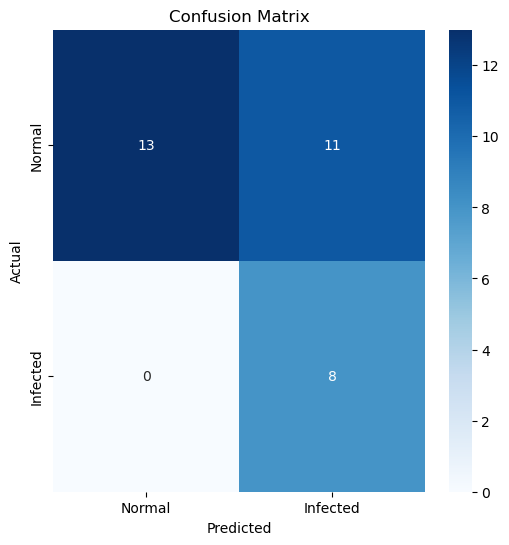

Accuracy: 0.66
Precision: 0.42
Recall: 1.00
F1 Score: 0.59


In [46]:

#### Generate Metrics and Report:
from sklearn.metrics import classification_report

# Flatten arrays for metrics calculation
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Metrics
accuracy = accuracy_score(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_flat, y_pred_flat, target_names=['Normal', 'Infected']))

# Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Infected'], yticklabels=['Normal', 'Infected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")



#### Additional Visualizations:
1. **ROC Curve**:

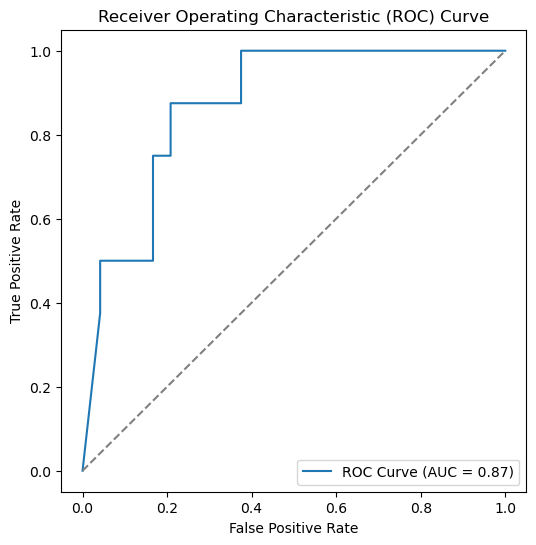

In [47]:

# ROC Curve
roc_auc = roc_auc_score(y_test_flat, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test_flat, y_pred_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


2. **Precision-Recall Curve**:

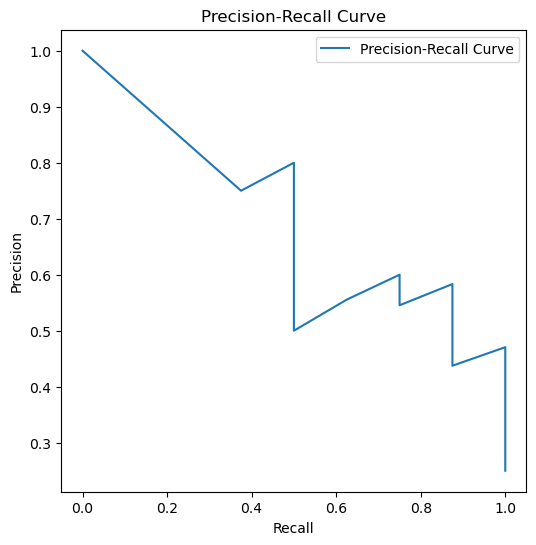

In [48]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test_flat, y_pred_prob)
plt.figure(figsize=(6, 6))
plt.plot(recall_vals, precision_vals, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

<h2 style='color:green'> Dataset 2 

<h3 style='color:red'>Large Dataset
<h4 style='color:purple'>Dynamic Data Loading with Generators


### 1: Classification using Best Models!

In [77]:
from PIL import Image
import os
import numpy as np
from tkinter import Tk
from tkinter.filedialog import askdirectory
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to browse and select a folder
def browse_folder(prompt):
    print(prompt)
    Tk().withdraw()
    return askdirectory(title=prompt)

# Function to dynamically load images using a generator
def image_data_generator(folder_paths, labels, target_size=(224, 224), batch_size=100):
    while True:
        for i in range(0, len(folder_paths), batch_size):
            batch_images = []
            batch_labels = []
            for j in range(i, min(i + batch_size, len(folder_paths))):
                file_path = folder_paths[j]
                label = labels[j]
                try:
                    # Load and preprocess the image
                    image = Image.open(file_path).convert('RGB').resize(target_size)
                    batch_images.append(np.array(image) / 255.0)  # Normalize image
                    batch_labels.append(label)
                except Exception as e:
                    print(f"Error loading image {file_path}: {e}")
            yield np.array(batch_images, dtype=np.float32), np.array(batch_labels, dtype=np.float32)

# Step 1: Select infected and normal image folders
print("Select the folder containing infected images: ", end=" ")  # Prompt without newline
infected_folder = browse_folder("")
print(infected_folder)

print("Select the folder containing normal images:", end=" ")  # Prompt without newline
normal_folder = browse_folder("")
print(normal_folder)

# Step 2: Generate file paths and labels
infected_paths = [os.path.join(infected_folder, file) for file in os.listdir(infected_folder) if file.lower().endswith(('.jpg', '.jpeg', '.png'))]
normal_paths = [os.path.join(normal_folder, file) for file in os.listdir(normal_folder) if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

all_paths = infected_paths + normal_paths
all_labels = [1] * len(infected_paths) + [0] * len(normal_paths)

print(f"Total infected images: {len(infected_paths)}")
print(f"Total normal images: {len(normal_paths)}")

# Step 3: Load the trained model
best_model = load_model('best_hyper_model.keras')

# Step 4: Perform predictions in batches
y_pred = []
y_true = []

test_gen = image_data_generator(all_paths, all_labels, target_size=(224, 224)) #, batch_size=32)

# Iterate over the generator
for batch_images, batch_labels in test_gen:
    batch_pred_prob = best_model.predict(batch_images)  # Predict probabilities
    y_pred.extend((batch_pred_prob > 0.5).astype(int))  # Convert to binary predictions
    y_true.extend(batch_labels)
    if len(y_pred) >= len(all_labels):  # Stop when all samples are processed
        break

# Step 5: Convert predictions and labels to NumPy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Step 6: Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print metrics
print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Select the folder containing infected images:  
D:/USD Univ. San Diego MS AI/AAI-521/Project Data/Standardized images/PCOS/PCOS/infected
Select the folder containing normal images: 
D:/USD Univ. San Diego MS AI/AAI-521/Project Data/Standardized images/PCOS/PCOS/noninfected
Total infected images: 6784
Total normal images: 5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
4/4 ━━━━━

### **B. Code Part 2: Generate a Complete Report and Visuals**


Classification Report:
              precision    recall  f1-score   support

      Normal       0.74      0.99      0.85      5000
    Infected       0.99      0.75      0.85      6784

    accuracy                           0.85     11784
   macro avg       0.87      0.87      0.85     11784
weighted avg       0.89      0.85      0.85     11784



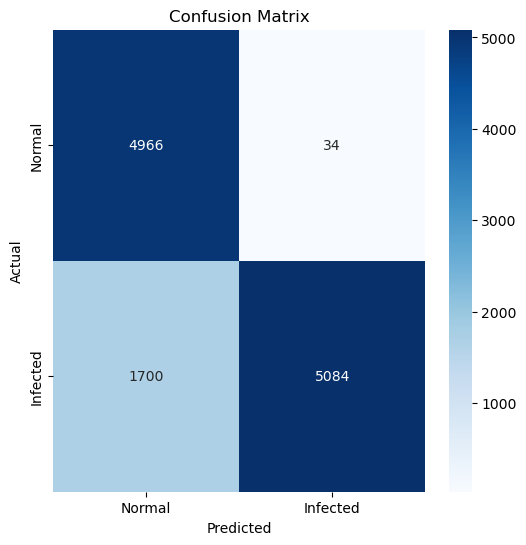

Accuracy: 0.85
Precision: 0.99
Recall: 0.75
F1 Score: 0.85


In [81]:
#### Generate Metrics and Report:
from sklearn.metrics import classification_report

# Flatten arrays for metrics calculation
y_test_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# Metrics
accuracy = accuracy_score(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_flat, y_pred_flat, target_names=['Normal', 'Infected']))

# Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Infected'], yticklabels=['Normal', 'Infected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")



-

### **Summary of Code Flow**:

1. **Folder Selection**:
   - The user selects folders containing **infected** and **normal** images.

2. **Image Loading**:
   - Images are loaded using the `image_data_generator()` function, which processes images in batches and normalizes them.
   - The labels are assigned as `1` for infected images and `0` for normal images.

3. **Model Loading**:
   - The trained model (`best_hyper_model.keras`) is loaded using `load_model()`.

4. **Prediction in Batches**:
   - Predictions are performed on batches of images using the generator. The model's predicted probabilities are converted to binary predictions based on a threshold of 0.5.

5. **Metrics Calculation**:
   - **Accuracy**, **Precision**, **Recall**, and **F1 Score** are calculated and printed.
   - The **Classification Report** is generated, providing a detailed breakdown of the model's performance for each class (Normal and Infected).

6. **Confusion Matrix**:
   - A confusion matrix is plotted to visualize the performance of the model in terms of true positives, false positives, true negatives, and false negatives.

---

### **Things to Note**:
- The **batch generator** helps efficiently load data in smaller batches, avoiding memory overload when dealing with large datasets.
- **Metrics** such as **Accuracy**, **Precision**, **Recall**, and **F1 Score** are computed using `sklearn` functions, and the **Classification Report** provides detailed performance evaluation.
- **Confusion Matrix** is displayed using **Seaborn** for visualization, making it easy to understand the modeurther assistance or modifications!

<h2 style='color:green'> Additional Visualizations:


### 1. **ROC Curve**:

### **Key Components of ROC Curve**
- **True Positive Rate (TPR)**: Also known as **Recall**, it is the proportion of actual positives correctly identified
  .
  \[
  \text{TPR} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
  \]

- **False Positive Rate (FPR)**: It is the proportion of actual negatives incorrectly identified as positives.
  \[
  \text{FPR} = \frac{\text{False Positives (FP)}}{\text{False Positives (FP)} + \text{True Negatives (TN)}}
  \]

- **ROC Curve**: The ROC curve plots the **TPR (y-axis)** against the **FPR (x-axis)** for different threshold values, where each point on the curve represents a specific threshold.

- **AUC (Area Under the Curve)**: The **AUC** represents the area under the ROC curve. A higher AUC indicates better model performance. A perfect classifier will have an AUC of **1**, while a random classifier will have an AUC of **0.5**.



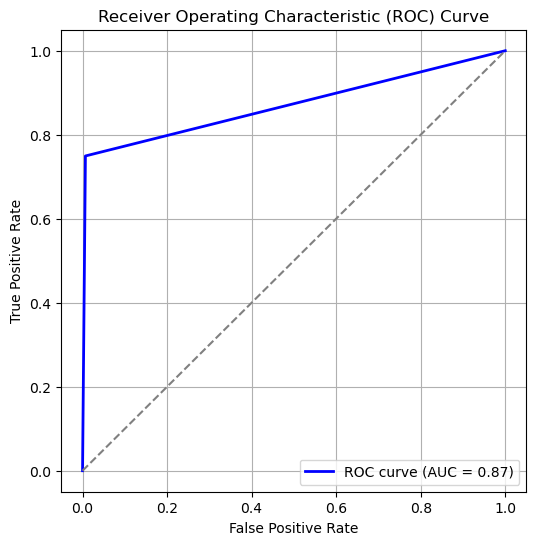

In [93]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)  # y_true: actual labels, y_pred: predicted probabilities
roc_auc = auc(fpr, tpr)  # Calculate the Area Under the Curve

# Step 2: Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


<span style='color:blue'> **Interpreting the ROC Curve:**

- **Ideal ROC Curve**: The curve should be as close as possible to the top-left corner, indicating a high **True Positive Rate** and low **False Positive Rate**.
- **AUC Value**:
  - **AUC = 1**: Perfect classifier (TPR = 1, FPR = 0).
  - **AUC = 0.5**: Random classifier (no better than random guessing).
  - **AUC < 0.5**: Worse than random (which suggests an issue with the model).ve class**.


### **How to Interpret ROC Curve**:

- The **leftmost part of the ROC curve** (when FPR is very low) corresponds to high **precision** (no false positives) but low **recall** (missed positives).
- The **rightmost part of the ROC curve** (when FPR = 1) corresponds to **perfect recall** (no false negatives), but **precision is low** due to high **false positive rate**.

### **Explanation of our Curve**

This behavior is indicative of a **trade-off between True Positive Rate (TPR) and False Positive Rate (FPR)**:

- **Initially** (when FPR = 0), the model is **highly conservative** and is correctly identifying only a subset of the positive instances with a low risk of false positives.
- As the **threshold for classification** is reduced, the model becomes more confident in predicting positives, **increasing recall** (TPR), but at the cost of also **increasing false positives** (FPR).
- When **FPR = 1**, the model is being **too aggressive**, classifying nearly all instances as positive, which results in perfect recall but a very high number of false positives.

This is the typical shape of a **classic ROC curve** for a **binary classifier** that operates with a decision threshold.

### **Why Does This Happen?**

- **Thresholding**: The ROC curve is a plot of the model's performance at various thresholds. As the threshold for classifying an instance as positive is lowered, the model starts predicting more positives (increasing **TPR**) but also more false positives (**FPR**).
  
- **Conservative Predictions**: At the start (with a high threshold), the model is **conservative**, only predicting positives when it’s highly confident, resulting in a low **TPR** and **FPR = 0**.
  
- **Aggressive Predictions**: As the threshold lowers, the model predicts more positives, which increases **TPR** (recall) but also increases **FPR**, ultimately leading to **FPR = 1** and **TPR = 1** when the model predicts all instances as positive.



### **What Should You Do About This?**

1. **Using AUC (Area Under the Curve)**:
   - The **AUC (Area Under the Curve)** provides a single number to summarize the model's performance across all thresholds. A higher AUC indicates a better-performing model.
   
  
2. **Precision-Recall Tradeoff**:
   - If your dataset is **imbalanced**, the **Precision-Recall curve** might be more informative than the ROC curve because the ROC curve can give overly optimistic results when the negative class is much larger than the positive class.

3. **Threshold Adjustment**:
   - If you want to reduce the **false positive rate** while still maintaining a decent **recall**, you can adjust the decision threshold. Instead of using the default threshold of 0.5, you can experiment with a higher threshold (e.g., 0.7 or 0.8), which will make the model more conservative.



### 2. **Precision-Recall Curve**:


<span style='color:blue'> **ROC Curve vs Precision-Recall Curve**

- The **ROC curve** is especially useful when the dataset is balanced. However, in the case of imbalanced datasets, the **Precision-Recall curve** might provide more meaningful insights because it focuses on the performance of the classifier with respect to the **positive class**.
- A **higher** Precision-Recall curve means **better performance**, especially when dealing with imbalanced datasets.
- Precision-Recall curves focus on how well the model predicts the **positive class**, unlike the ROC curve, which can be overly optimistic for imbalanced datasets.


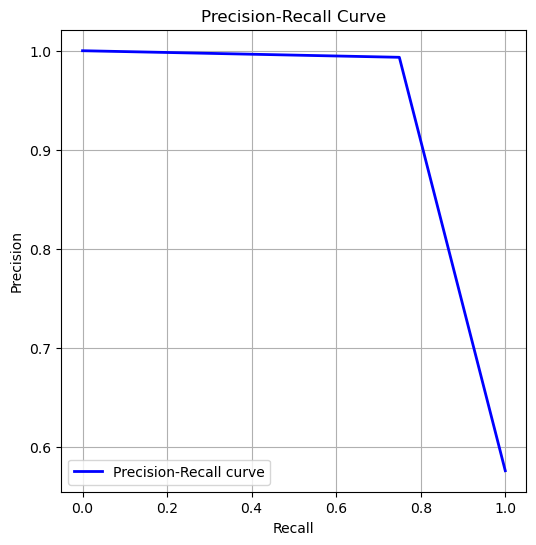

In [92]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Step 1: Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)  # y_true: actual labels, y_pred: predicted probabilities

# Step 2: Plot the Precision-Recall curve
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


### **How to Interpret This Curve**:

- **High precision at first**: Our model is quite good at identifying positives with a high level of certainty but only for a subset of the positive cases (low recall).
- **Drop in precision**: As recall increases, the model starts predicting more positives, but it becomes less accurate (more false positives), causing precision to fall.

### **Explanation of the Curve Behavior:**

- **Precision near 1 until Recall ~0.7**: 
  - This means that when the recall is low, the model is making predictions with a very high precision. It's correctly identifying positive instances without many false positives. This suggests that the model is very conservative in its positive predictions, only classifying as positive when it is quite sure.
  
- **Drop in Precision at Recall = 1**:
  - As the recall increases to 1 (i.e., the model starts to predict **all** positive instances), **precision drops** significantly. This happens because the model is classifying more instances as positive, but many of them are actually false positives (incorrectly labeled as positive).
  - At **recall = 1**, the model is identifying all positive instances, but because it's now labeling many more instances as positive (perhaps incorrectly), **precision decreases**. Essentially, the model is getting more **false positives** as it tries to capture every possible positive.

### **Why This Happens**:

1. **Imbalanced Dataset**:
   - If our dataset is imbalanced (e.g., a small number of infected images compared to normal images), the model might predict **mostly negative** and only classify as positive when it's quite confident. As you move toward **100% recall**, the model starts to classify more instances as positive, which might include many **false positives**, thereby lowering **precision**.

2. **Threshold Choice**:
   - The **precision-recall curve** depends on the **threshold** chosen for classification (e.g., if the predicted probability of a positive class is greater than 0.5, it is classified as positive). If the model is **over-predicting positives** when the threshold is lower, it will result in a drop in precision.


### **Suggestions for Improvement**:

1. **Adjust the Decision Threshold**:
   - If the model is **overpredicting** positives (hence lowering precision), we can adjust the **decision threshold** for classifying an instance as positive.
     - Example: Instead of using a threshold of 0.5 (where probabilities above 0.5 are classified as positive), we can use a higher threshold (e.g., 0.7 or 0.8) to be more confident in the positive predictions.



<h2 style='color:Green'> The behavior of both curves is a typical characteristic of 
<h4 style='color:Blue'>   
    - Imbalanced Dataset problem <br>
    - Low threshold problem


<h2 style='color:green'> Dataset 2 

<h3 style='color:red'>Large Dataset 
</h3>

--------
    - Balanced [Dynamic checking]
    - Increased Threshold [0.65]
-------
<h4 style='color:purple'>Dynamic Data Loading with Generators


### 1: Classification using Best Models!

Select the folder containing infected images:  
D:/USD Univ. San Diego MS AI/AAI-521/Project Data/Standardized images/PCOS/PCOS/infected
Select the folder containing normal images: 
D:/USD Univ. San Diego MS AI/AAI-521/Project Data/Standardized images/PCOS/PCOS/noninfected

---Dataset: 11784 images (Infected: 6784, Normal: 5000)---

---Balanced dataset: 10000 images (Infected: 5000, Normal: 5000)---

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step
4/4 ━━━━━━━

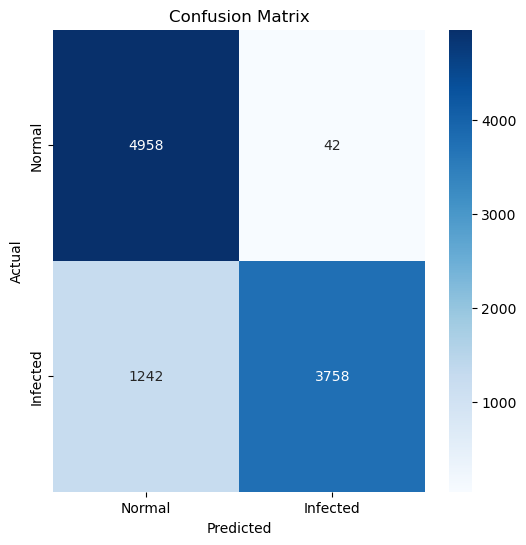

In [119]:
from PIL import Image
import os
import numpy as np
from tkinter import Tk
from tkinter.filedialog import askdirectory
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to browse and select a folder
def browse_folder(prompt):
    print(prompt)
    Tk().withdraw()
    return askdirectory(title=prompt)

# Function to dynamically load images using a generator
def image_data_generator(folder_paths, labels, target_size=(224, 224), batch_size=100):
    while True:
        for i in range(0, len(folder_paths), batch_size):
            batch_images = []
            batch_labels = []
            for j in range(i, min(i + batch_size, len(folder_paths))):
                file_path = folder_paths[j]
                label = labels[j]
                try:
                    # Load and preprocess the image
                    image = Image.open(file_path).convert('RGB').resize(target_size)
                    batch_images.append(np.array(image) / 255.0)  # Normalize image
                    batch_labels.append(label)
                except Exception as e:
                    print(f"Error loading image {file_path}: {e}")
            yield np.array(batch_images, dtype=np.float32), np.array(batch_labels, dtype=np.float32)

# Step 1: Select infected and normal image folders
print("Select the folder containing infected images: ", end=" ")  # Prompt without newline
infected_folder = browse_folder("")
print(infected_folder)

print("Select the folder containing normal images:", end=" ")  # Prompt without newline
normal_folder = browse_folder("")
print(normal_folder)

# Step 2: Generate file paths and labels
infected_paths = [os.path.join(infected_folder, file) for file in os.listdir(infected_folder) if file.lower().endswith(('.jpg', '.jpeg', '.png'))]
normal_paths = [os.path.join(normal_folder, file) for file in os.listdir(normal_folder) if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Step 3: Dynamically label images
# Assign 1 for infected and 0 for normal based on folder association
infected_labels = [1] * len(infected_paths)  # Label infected images as 1
normal_labels = [0] * len(normal_paths)  # Label normal images as 0

# *************************************************************************************

# Step 4: Balance the dataset
# Identify the smaller class
num_infected = len(infected_paths)
num_normal = len(normal_paths)

# Check the size of the given dataset
print(f"\n---Dataset: {num_infected + num_normal} images (Infected: {num_infected}, Normal: {num_normal})---")


if num_infected < num_normal:
    smaller_class_size = num_infected
    balanced_infected_paths = infected_paths
    balanced_normal_paths = np.random.choice(normal_paths, smaller_class_size, replace=False)
else:
    smaller_class_size = num_normal
    balanced_normal_paths = normal_paths
    balanced_infected_paths = np.random.choice(infected_paths, smaller_class_size, replace=False)

# Now, create the balanced dataset by combining the smaller class and balanced larger class
balanced_paths = list(balanced_infected_paths) + list(balanced_normal_paths)
balanced_labels = [1] * len(balanced_infected_paths) + [0] * len(balanced_normal_paths)

# *************************************************************************************

# Check the size of the balanced dataset
print(f"\n---Balanced dataset: {len(balanced_paths)} images (Infected: {len(balanced_infected_paths)}, Normal: {len(balanced_normal_paths)})---\n")

# Step 5: Load the trained model
best_model = load_model('best_hyper_model.keras')

# Step 6: Perform predictions in batches
y_pred = []
y_true = []

test_gen = image_data_generator(balanced_paths, balanced_labels, target_size=(224, 224))

# Iterate over the generator
count=1
for batch_images, batch_labels in test_gen:
    batch_pred_prob = best_model.predict(batch_images)  # Predict probabilities
    print(f"\r{count}. ", flush=True)
    count+=1

    # *************************************************************************************
    # Increased Threshold
    threshold=0.4
    y_pred.extend((batch_pred_prob > threshold).astype(int))  # Convert to binary predictions
    # *************************************************************************************
    
    y_true.extend(batch_labels)
    if len(y_pred) >= len(balanced_labels):  # Stop when all samples are processed
        break

# Step 7: Convert predictions and labels to NumPy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Step 8: Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print metrics
print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Step 9: Classification Report
from sklearn.metrics import classification_report

# Flatten arrays for metrics calculation
y_test_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# Print classification report
print("Classification Report:")
print(classification_report(y_test_flat, y_pred_flat, target_names=['Normal', 'Infected']))

# Step 10: Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Infected'], yticklabels=['Normal', 'Infected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### **B. Code Part 2: Generate a Complete Report and Visuals**


The Classification Threshold is set at: 0.7

Performance Metrics:
Accuracy: 0.87
Precision: 0.99
Recall: 0.75
F1 Score: 0.85
Classification Report:
              precision    recall  f1-score   support

      Normal       0.80      1.00      0.88      5000
    Infected       0.99      0.75      0.85      5000

    accuracy                           0.87     10000
   macro avg       0.89      0.87      0.87     10000
weighted avg       0.89      0.87      0.87     10000



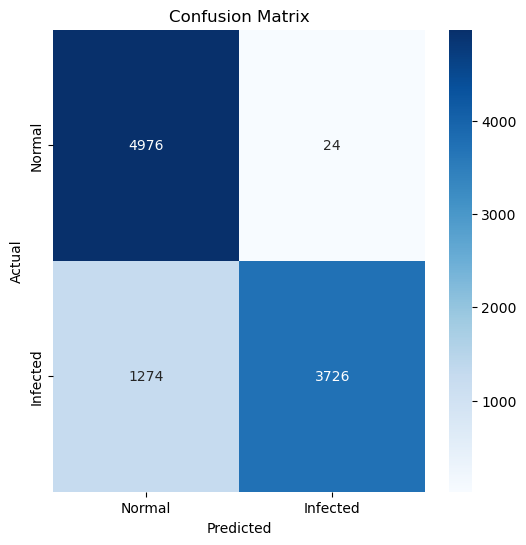

Accuracy: 0.87
Precision: 0.99
Recall: 0.75
F1 Score: 0.85


In [117]:
print("The Classification Threshold is set at:", threshold)

# Generate Metrics and Report:
from sklearn.metrics import classification_report

# Flatten arrays for metrics calculation
y_test_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# Print metrics
print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Metrics
accuracy = accuracy_score(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_flat, y_pred_flat, target_names=['Normal', 'Infected']))

# Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Infected'], yticklabels=['Normal', 'Infected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")



The Classification Threshold is set at: 0.65

Performance Metrics:
Accuracy: 0.87
Precision: 0.99
Recall: 0.75
F1 Score: 0.85
Classification Report:
              precision    recall  f1-score   support

      Normal       0.80      0.99      0.88      5000
    Infected       0.99      0.75      0.85      5000

    accuracy                           0.87     10000
   macro avg       0.89      0.87      0.87     10000
weighted avg       0.89      0.87      0.87     10000



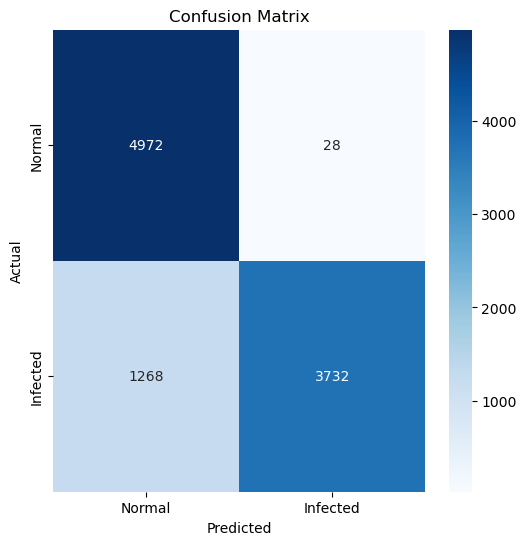

Accuracy: 0.87
Precision: 0.99
Recall: 0.75
F1 Score: 0.85


In [115]:
print("The Classification Threshold is set at:", threshold)

# Generate Metrics and Report:
from sklearn.metrics import classification_report

# Flatten arrays for metrics calculation
y_test_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# Print metrics
print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Metrics
accuracy = accuracy_score(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_flat, y_pred_flat, target_names=['Normal', 'Infected']))

# Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Infected'], yticklabels=['Normal', 'Infected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")



### **Summary of Code Flow**:

1. **Folder Selection**:
   - The user selects folders containing **infected** and **normal** images.

2. **Image Loading**:
   - Images are loaded using the `image_data_generator()` function, which processes images in batches and normalizes them.
   - The labels are assigned as `1` for infected images and `0` for normal images.

3. **Model Loading**:
   - The trained model (`best_hyper_model.keras`) is loaded using `load_model()`.

4. **Prediction in Batches**:
   - Predictions are performed on batches of images using the generator. The model's predicted probabilities are converted to binary predictions based on a threshold of 0.5.

5. **Metrics Calculation**:
   - **Accuracy**, **Precision**, **Recall**, and **F1 Score** are calculated and printed.
   - The **Classification Report** is generated, providing a detailed breakdown of the model's performance for each class (Normal and Infected).

6. **Confusion Matrix**:
   - A confusion matrix is plotted to visualize the performance of the model in terms of true positives, false positives, true negatives, and false negatives.

---

### **Things to Note**:
- The **batch generator** helps efficiently load data in smaller batches, avoiding memory overload when dealing with large datasets.
- **Metrics** such as **Accuracy**, **Precision**, **Recall**, and **F1 Score** are computed using `sklearn` functions, and the **Classification Report** provides detailed performance evaluation.
- **Confusion Matrix** is displayed using **Seaborn** for visualization, making it easy to understand the model's strengths and weaknesses.


<h2 style='color:green'> Additional Visualizations:


### 1. **ROC Curve**:

### **Key Components of ROC Curve**
- **True Positive Rate (TPR)**: Also known as **Recall**, it is the proportion of actual positives correctly identified
  .
  \[
  \text{TPR} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
  \]

- **False Positive Rate (FPR)**: It is the proportion of actual negatives incorrectly identified as positives.
  \[
  \text{FPR} = \frac{\text{False Positives (FP)}}{\text{False Positives (FP)} + \text{True Negatives (TN)}}
  \]

- **ROC Curve**: The ROC curve plots the **TPR (y-axis)** against the **FPR (x-axis)** for different threshold values, where each point on the curve represents a specific threshold.

- **AUC (Area Under the Curve)**: The **AUC** represents the area under the ROC curve. A higher AUC indicates better model performance. A perfect classifier will have an AUC of **1**, while a random classifier will have an AUC of **0.5**.



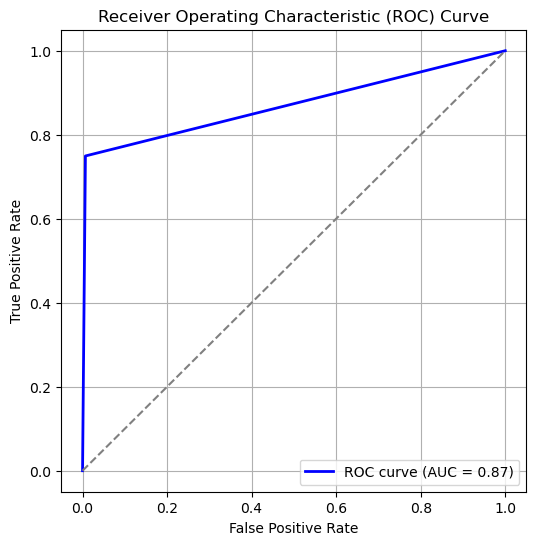

In [93]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)  # y_true: actual labels, y_pred: predicted probabilities
roc_auc = auc(fpr, tpr)  # Calculate the Area Under the Curve

# Step 2: Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


<span style='color:blue'> **Interpreting the ROC Curve:**

- **Ideal ROC Curve**: The curve should be as close as possible to the top-left corner, indicating a high **True Positive Rate** and low **False Positive Rate**.
- **AUC Value**:
  - **AUC = 1**: Perfect classifier (TPR = 1, FPR = 0).
  - **AUC = 0.5**: Random classifier (no better than random guessing).
  - **AUC < 0.5**: Worse than random (which suggests an issue with the model).ve class**.


### 2. **Precision-Recall Curve**:


<span style='color:blue'> **ROC Curve vs Precision-Recall Curve**

- The **ROC curve** is especially useful when the dataset is balanced. However, in the case of imbalanced datasets, the **Precision-Recall curve** might provide more meaningful insights because it focuses on the performance of the classifier with respect to the **positive class**.
- A **higher** Precision-Recall curve means **better performance**, especially when dealing with imbalanced datasets.
- Precision-Recall curves focus on how well the model predicts the **positive class**, unlike the ROC curve, which can be overly optimistic for imbalanced datasets.


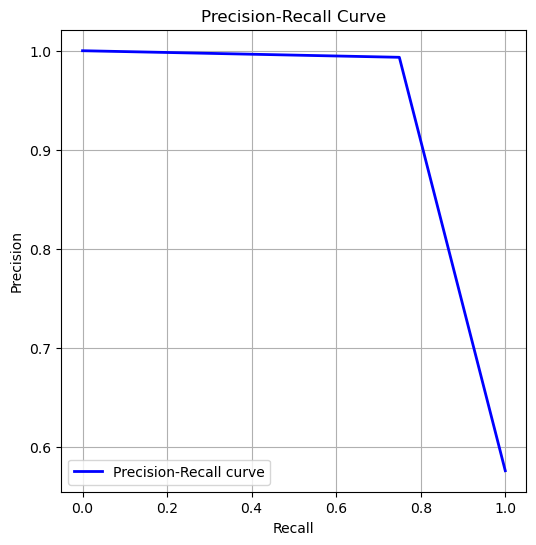

In [92]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Step 1: Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)  # y_true: actual labels, y_pred: predicted probabilities

# Step 2: Plot the Precision-Recall curve
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


<h3 style='color:purple'> The behavior of Precision-Recall curve is a typical characteristic of imbalanced classification problems. 


Reloading Tuner from hyperparam_tuning\cnn_tuning\tuner0.jso

n
C:\Users\Soumiz\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables.
  
  
  trackable.load_own_variables(weights_store.get(inner_pat

  h))
Best Hyperparamete>rs:
Filters>: 32
Learning Rate: 0>.0001
Dense Unit>s: 256
Dropout Ra>te: 0.2
Number of Conv 
>


Layers: 3
Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 68s 597ms/step - accuracy: 0.9980 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: <br> 7.6820e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 540ms/step - accuracy: 1.0000 - loss: 3.2279e-04 - val_accuracy: 1.0000 - val_los <br>s: 3.0303e-04
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 535ms/step - accuracy: 1.0000 - loss: 2.3999e-04 - val_accuracy: 1.0000 - val_l <br>oss: 2.7109e-04
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 536ms/step - accuracy: 1.0000 - loss: 9.2453e-05 - val_accuracy: 1.0000 - <br> val_loss: 0.0011
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 55s 564ms/step - accuracy: 1.0000 - loss: 1.2722e-04 - val_accuracy: 1.0000 - v <br>al_loss: 2.7327e-04
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 542ms/step - accuracy: 1.0000 - loss: 3.2530e-05 - val_accuracy: 1.0000 - <br> val_loss: 3.0677e-04
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 540ms/step - accuracy: 1.0000 - loss: 2.3875e-05 - val_accuracy: 1.0000 <br> - val_loss: 2.2284e-04
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 541ms/step - accuracy: 1.0000 - loss: 1.5918e-05 - val_accuracy: 1.00 <br>00 - val_loss: 1.3690e-04
Epoch 9/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 541ms/step - accuracy: 1.0000 - loss: 1.7673e-05 - val_accuracy: 1. <br>0000 - val_loss: 1.2127e-04
Epoch 10/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 541ms/step - accuracy: 1.0000 - loss: 7.3572e-06 - val_accuracy:  <br>1.0000 - val_loss: 1.2676e-04
Epoch 11/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 559ms/step - accuracy: 1.0000 - loss: 9.1109e-06 - val_accuracy <br>: 1.0000 - val_loss: 6.0049e-05
Epoch 12/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 546ms/step - accuracy: 1.0000 - loss: 1.0308e-05 - val_accura <br>cy: 1.0000 - val_loss: 3.8510e-05
Epoch 13/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 547ms/step - accuracy: 1.0000 - loss: 6.7822e-06 - val_accu <br>racy: 1.0000 - val_loss: 7.2966e-05
Epoch 14/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 544ms/step - accuracy: 1.0000 - loss: 4.7299e-06 - val_ac <br>curacy: 1.0000 - val_loss: 7.2043e-05
Epoch 15/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 541ms/step - accuracy: 1.0000 - loss: 7.3594e-06 - val_ <br>accuracy: 1.0000 - val_loss: 6.0872e-05
Epoch 16/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 553ms/step - accuracy: 1.0000 - loss: 4.4803e-06 - va <br>l_accuracy: 1.0000 - val_loss: 5.2454e-05
Epoch 17/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 556ms/step - accuracy: 1.0000 - loss: 4.1273e-06 -  <br>val_accuracy: 1.0000 - val_loss: 8.3478e-05
Epoch 18/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 543ms/step - accuracy: 1.0000 - loss: 2.6324e-06  <br>- val_accuracy: 1.0000 - val_loss: 5.5653e-05
Epoch 19/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 541ms/step - accuracy: 1.0000 - loss: 2.3818e-0 <br>6 - val_accuracy: 1.0000 - val_loss: 2.8953e-05
Epoch 20/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 542ms/step - accuracy: 1.0000 - loss: 3.3679e <br>-06 - val_accuracy: 1.0000 - val_loss: 3.2909e-05


# Hyperparameter Tuning Results

### Trial 18 Complete
- **Time Taken**: 00h 19m 23s
- **Validation Accuracy**: 1.0

### Best Validation Accuracy So Far
- **Value**: 1.0
- **Elapsed Time**: 13h 21m 26s

---

### Trial #19: Hyperparameters

| Hyperparameter   | Value         | Best Value So Far |
|------------------|---------------|-------------------|
| `filters`        | 128           | 128               |
| `num_conv_layers`| 1             | 1                 |
| `conv_0_filters` | 128           | 64                |
| `dense_units`    | 64            | 256               |
| `dropout`        | 0.2           | 0.2               |
| `learning_rate`  | 0.001         | 0.001             |
| `conv_1_filters` | 64            | 128               |
| `conv_2_filters` | 64            | None              |

---

### Training Logs

#### Epoch 1/10
- Accuracy: **0.7875**
- Loss: **0.7946**
- Validation Accuracy: **0.9974**
- Validation Loss: **0.0074**

#### Epoch 2/10
- Accuracy: **0.9892**
- Loss: **0.0300**
- Validation Accuracy: **0.9948**
- Validation Loss: **0.0156**

#### Epoch 3/10
- Accuracy: **0.9945**
- Loss: **0.0202**
- Validation Accuracy: **0.9922**
- Validation Loss: **0.0398**

#### Epoch 4/10
- Accuracy: **0.9938**
- Loss: **0.0153**
- Validation Accuracy: **0.9974**
- Validation Loss: **0.0124**

#### Epoch 5/10
- Accuracy: **0.9999**
- Loss: **7.2114e-04**
- Validation Accuracy: **0.9792**
- Validation Loss: **0.0521**

#### Epoch 6/10
- Accuracy: **0.9976**
- Loss: **0.0080**
- Validation Accuracy: **0.9896**
- Validation Loss: **0.0290**

#### Epoch 7/10
- Accuracy: **1.0000**
- Loss: **0.0077**
- Validation Accuracy: **1.0000**
- Validation Loss: **4.0199e-04**

#### Epoch 8/10
- Accuracy: **0.9969**
- Loss: **0.0078**
- Validation Accuracy: **1.0000**
- Validation Loss: **8.1942e-04**

#### Epoch 9/10
- Accuracy: **1.0000**
- Loss: **1.3467e-04**
- Validation Accuracy: **1.0000**
- Validation Loss: **1.2518e-04**

#### Epoch 10/10
- Accuracy: **1.0000**
- Loss: **2.1381e-04**
- Validation Accuracy: **0.9065**
- Validation Loss: **0.7774**

---

### Observations
- Training accuracy consistently reaches **1.0**, but the validation accuracy fluctuates.
- Overfitting is evident in later epochs as the validation loss increases dramatically.


Trial 18 Complete [00h 19m 23s]<br>
val_accuracy: 1.0<br>
<br>
Best val_accuracy So Far: 1.0<br>
Total elapsed time: 13h 21m 26s<br>
<br>
Search: Running Trial #19
<br>

| Value   | Best Value So Far | Hyperparameter       |
|---------|-------------------|----------------------|
| 128     | 128               | filters             |
| 1       | 1                 | num_conv_layers     |
| 128     | 64                | conv_0_filters      |
| 64      | 256               | dense_units         |
| 0.2     | 0.2               | dropout             |
| 0.001   | 0.001             | learning_rate       |
| 64      | 128               | conv_1_filters      |
| 64      | None              | conv_2_filters      |




   <br> 
     <br>
<br>
Epoch 1/10<br>
97/97 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.7875 - loss: 0.7946 - val_accuracy: 0.9974 - val_loss: 0.0074<br>
Epoch 2/10<br>
97/97 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.9892 - loss: 0.0300 - val_accuracy: 0.9948 - val_loss: 0.0156<br>
Epoch 3/10<br>
97/97 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.9945 - loss: 0.0202 - val_accuracy: 0.9922 - val_loss: 0.0398<br>
Epoch 4/10<br>
97/97 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.9938 - loss: 0.0153 - val_accuracy: 0.9974 - val_loss: 0.0124<br>
Epoch 5/10<br>
97/97 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.9999 - loss: 7.2114e-04 - val_accuracy: 0.9792 - val_loss: 0.0521<br>
Epoch 6/10<br>
97/97 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.9976 - loss: 0.0080 - val_accuracy: 0.9896 - val_loss: 0.0290<br>
Epoch 7/10<br>
97/97 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 4.0199e-04<br>
Epoch 8/10<br>
97/97 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.9969 - loss: 0.0078 - val_accuracy: 1.0000 - val_loss: 8.1942e-04<br>
Epoch 9/10<br>
97/97 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 1.0000 - loss: 1.3467e-04 - val_accuracy: 1.0000 - val_loss: 1.2518e-04<br>
Epoch 10/10<br>
97/97 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 1.0000 - loss: 2.1381e-04 - val_accuracy: 0.9065 - val_loss: 0.7774<br>
Epoch 1/10<br>
30/97 ━━━━━━━━━━━━━━━━━━━━ 2:49 3s/step - accuracy: 0.6574 - loss: 1.9909<br><br>

step - accuracy: 0.6574 - loss: 1.9909


------------
Trial 19 Complete [01h 27m 03s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 14h 48m 29s

Search: Running Trial| #20

Value             |Best Value So Fararameter |Hyperp|
|--------------|----------------------|------||rameter
64                |128           | ||||filters
2                 |1             o |num_c|o|||nv_layers
64                |64              |con|v|||_0_filters
128               |2          |||||dense_units
0.2               |         | |||    |dropout
0.001             |0.0            |||||learning_rate
128               |12             |||||conv_1_filters
128               |N             |

| |conv_2_filters

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.7836 - loss: 0.6670 - val_accuracy: 0.9948 - val_loss: 0.0110
Epoch 2/10
37/97 ━━━━━━━━━━━━━━━━━━━━ 58s 978ms/step - accuracy: 0.9925 - loss: 0.0183
ccuracy: 0.6574 - loss: 1.9909


### **4. Recommended Search Ranges**:
- **Filters**: `[32, 64, 128, 256]`
- **Dense Units**: `[64, 128, 256, 512]`
- **Dropout Rate**: `[0.2, 0.3, 0.4, 0.5]`
- **Learning Rate**: `[1e-2, 1e-3, 1e-4]`
- **Batch Size**: `[16, 32, 64]`
- **Number of Conv Layers**: `[2, 3, 4]`

---

### **5. Advantages of Hyperparameter Tuning**:
- Improves model performance by identifying optimal configurations.
- Reduces overfitting or underfitting.
- Ensures a more generalizable model.
